# 커널 서포트 벡터 머신

## XOR 문제

퍼셉트론이나 서포트 벡터 머신과 같은 선형판별함수 분류모형은 다음과 같은 XOR(exclusive OR) 문제를 풀지 못한다는 단점이 있다. 

| | X2=0 | X2=1 |
|-|-|-|
|X1=0| 0 | 1 |
|X1=1| 1 | 0 | 

이러한 경우에는 다음 그림에서 보듯이 선형판별평면(decision hyperplane)으로 영역을 나눌 수 없기 때문이다.

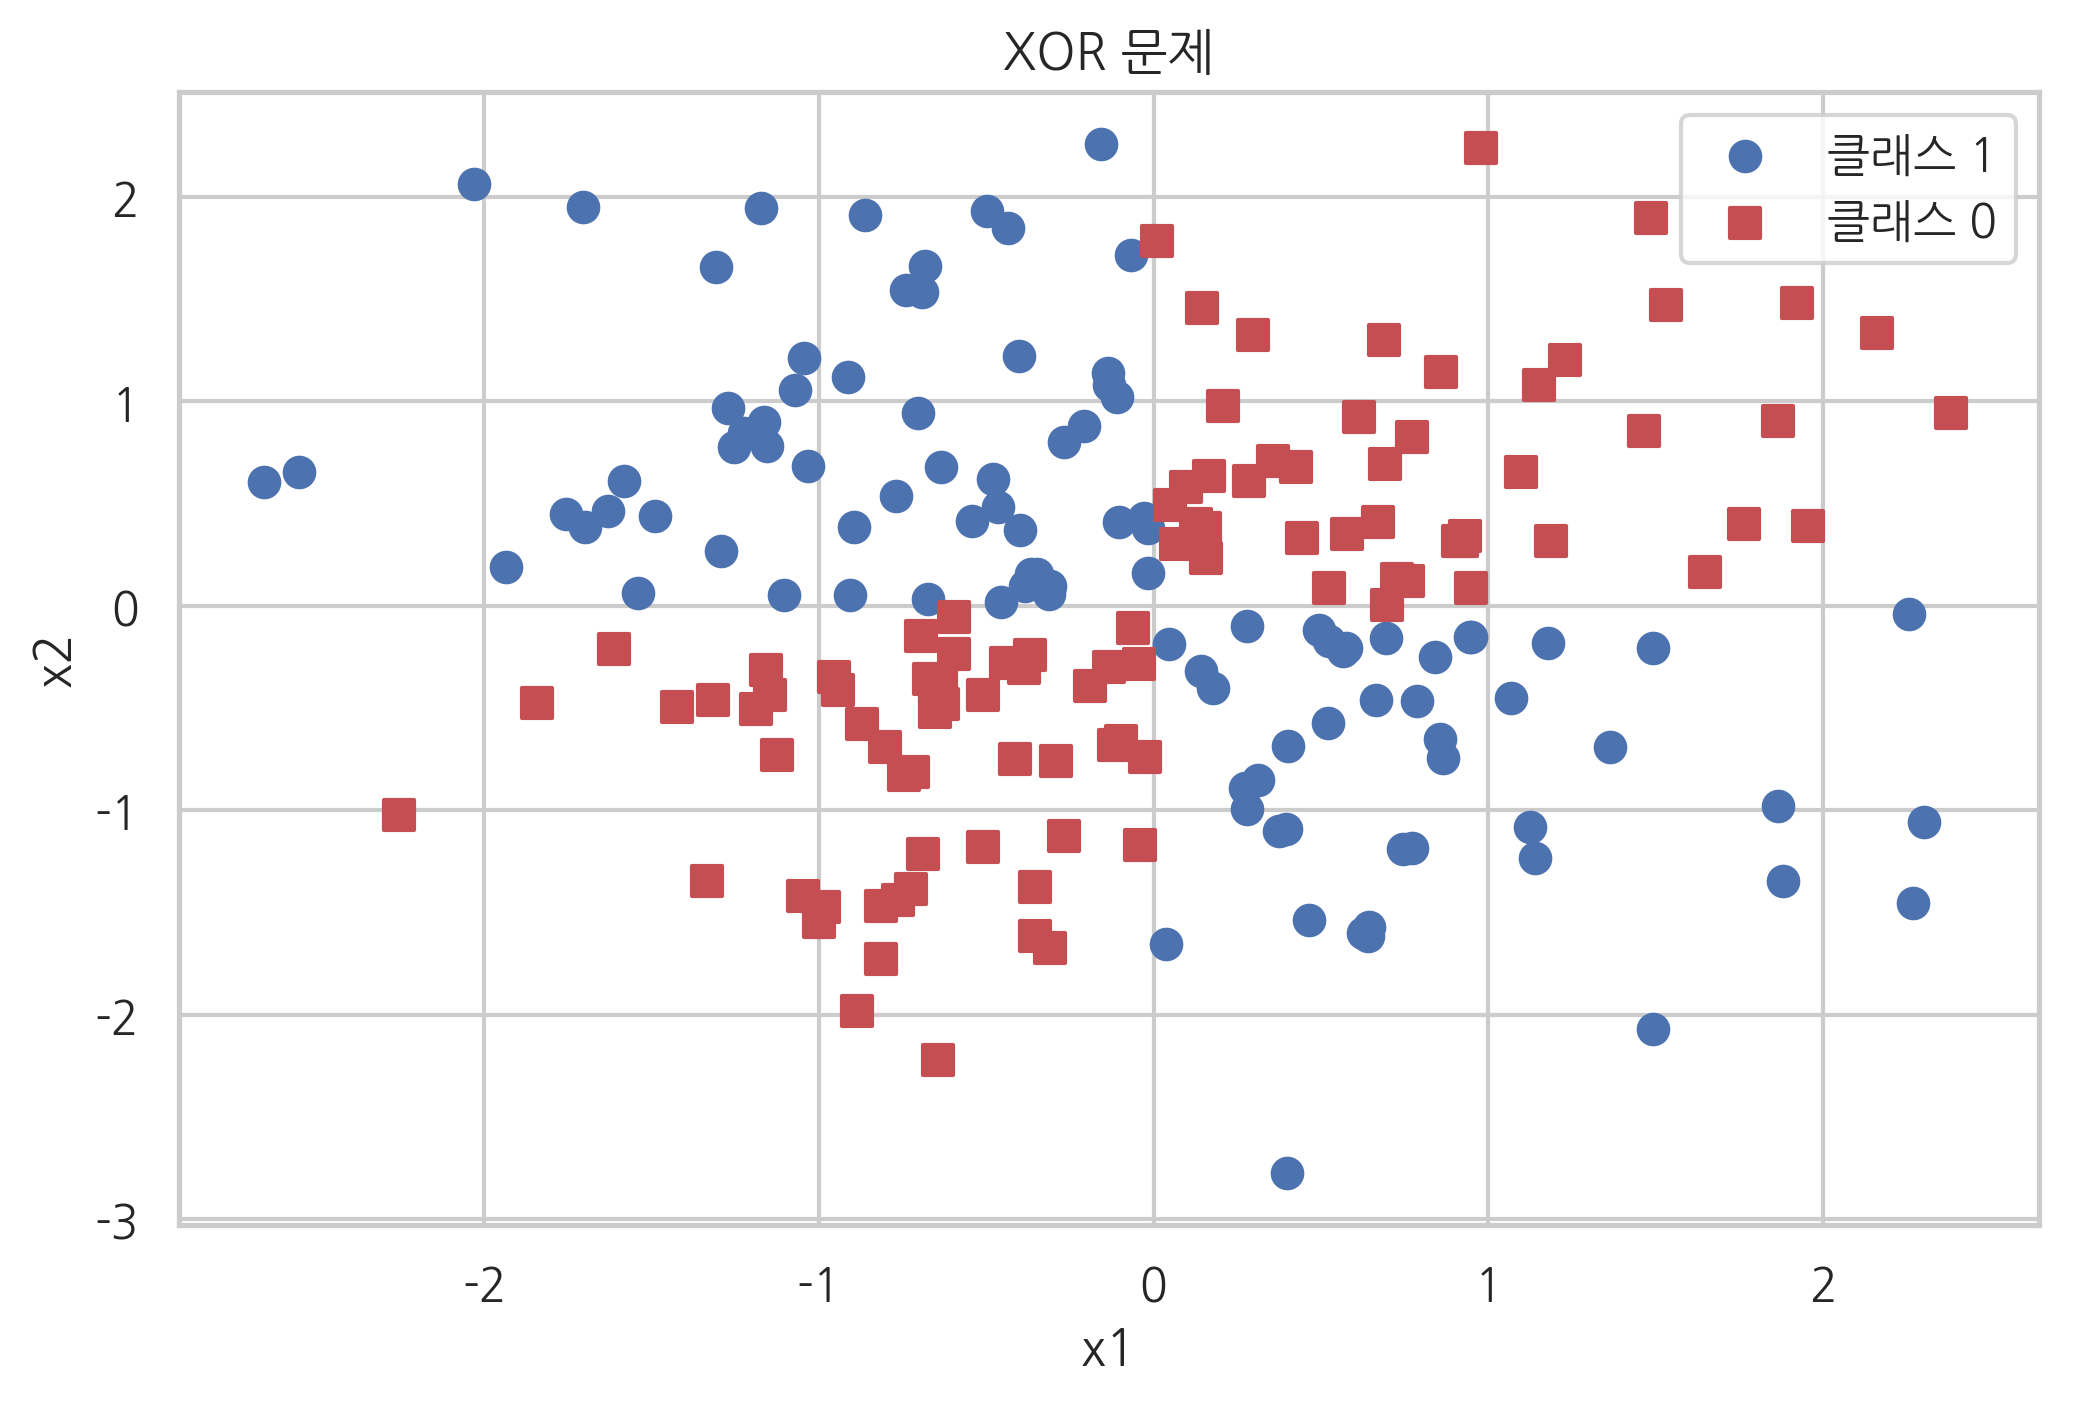

In [1]:
np.random.seed(0)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
            c='b', marker='o', label='클래스 1', s=50)
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1],
            c='r', marker='s', label='클래스 0', s=50)
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("XOR 문제")
plt.show()

선형 SVM을 사용하면 XOR문제를 풀 수 없다.

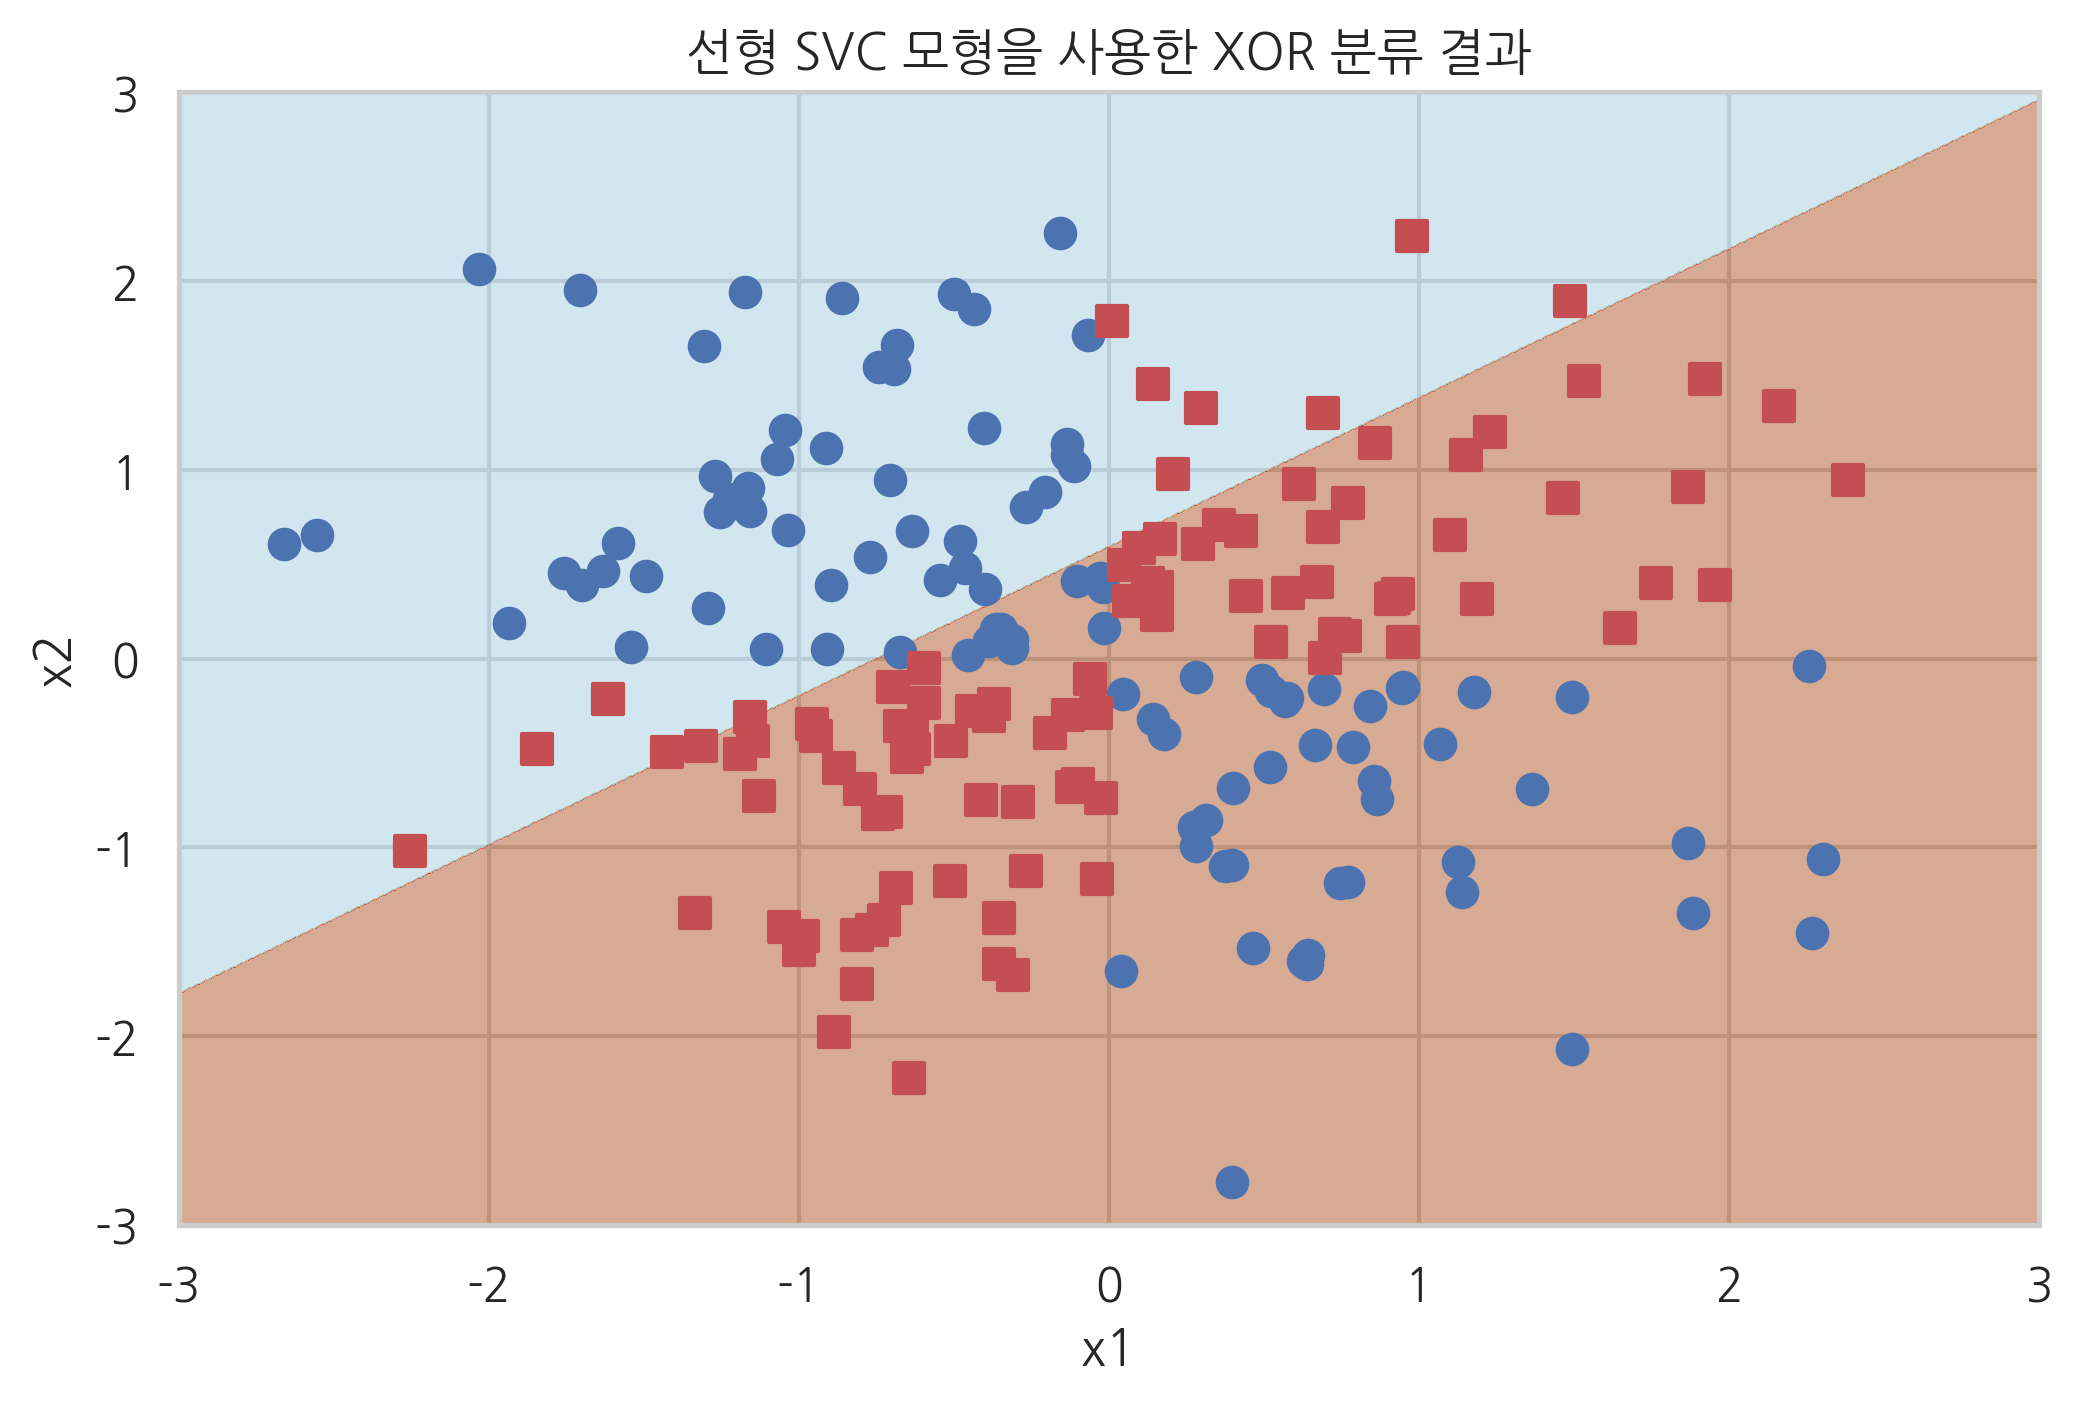

In [2]:
def plot_xor(X, y, model, title, xmin=-3, xmax=3, ymin=-3, ymax=3):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(
        np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b',
                marker='o', label='클래스 1', s=50)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r',
                marker='s', label='클래스 0', s=50)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

from sklearn.svm import SVC

svc = SVC(kernel="linear").fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, svc, "선형 SVC 모형을 사용한 XOR 분류 결과")
plt.show()

## 기저함수를 사용한 비선형 판별 모형

이러한 경우 도움이 되는 것이 원래의 $D$ 차원 독립 변수 벡터 $x$ 대신 기저함수(basis function)으로 변환한 $M$ 차원 벡터 $\phi(x)$를 독립 변수 벡터로 사용하는 방법이다.

$$ \phi(\cdot): {R}^D \rightarrow {R}^M $$

$$ x=(x_1, x_2, \cdots, x_D) \;\;\; \rightarrow \;\;\; \phi(x) = (\phi_1(x), \phi_2(x), \cdots, \phi_M(x)) $$

앞서 XOR 문제를 풀기 위해 다음과 같이 상호 곱(cross-multiplication) 항을 추가한 기저함수를 사용해 보자.


$$ (x_1, x_2) \;\;\; \rightarrow \;\;\; \phi(x) = (x_1^2, \sqrt{2}x_1x_2, x_2^2) $$

In [3]:
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

`FunctionTransformer` 전처리 클래스로 위와 기저함수를 이용한 특징 변환을 할 수 있다.

In [4]:
from sklearn.preprocessing import FunctionTransformer

def basis(X):
    return np.vstack([X[:, 0]**2, np.sqrt(2)*X[:, 0]*X[:, 1], X[:, 1]**2]).T

FunctionTransformer(basis).fit_transform(X)

array([[ 0.        ,  0.        ,  1.        ],
       [ 4.        ,  8.48528137,  9.        ],
       [16.        , 28.28427125, 25.        ]])

위와 같은 기저함수를 써서 XOR 문제의 데이터를 변환하면 특성 $\phi_2$를 사용하여 클래스 분류를 할 수 있다는 것을 알 수 있다.

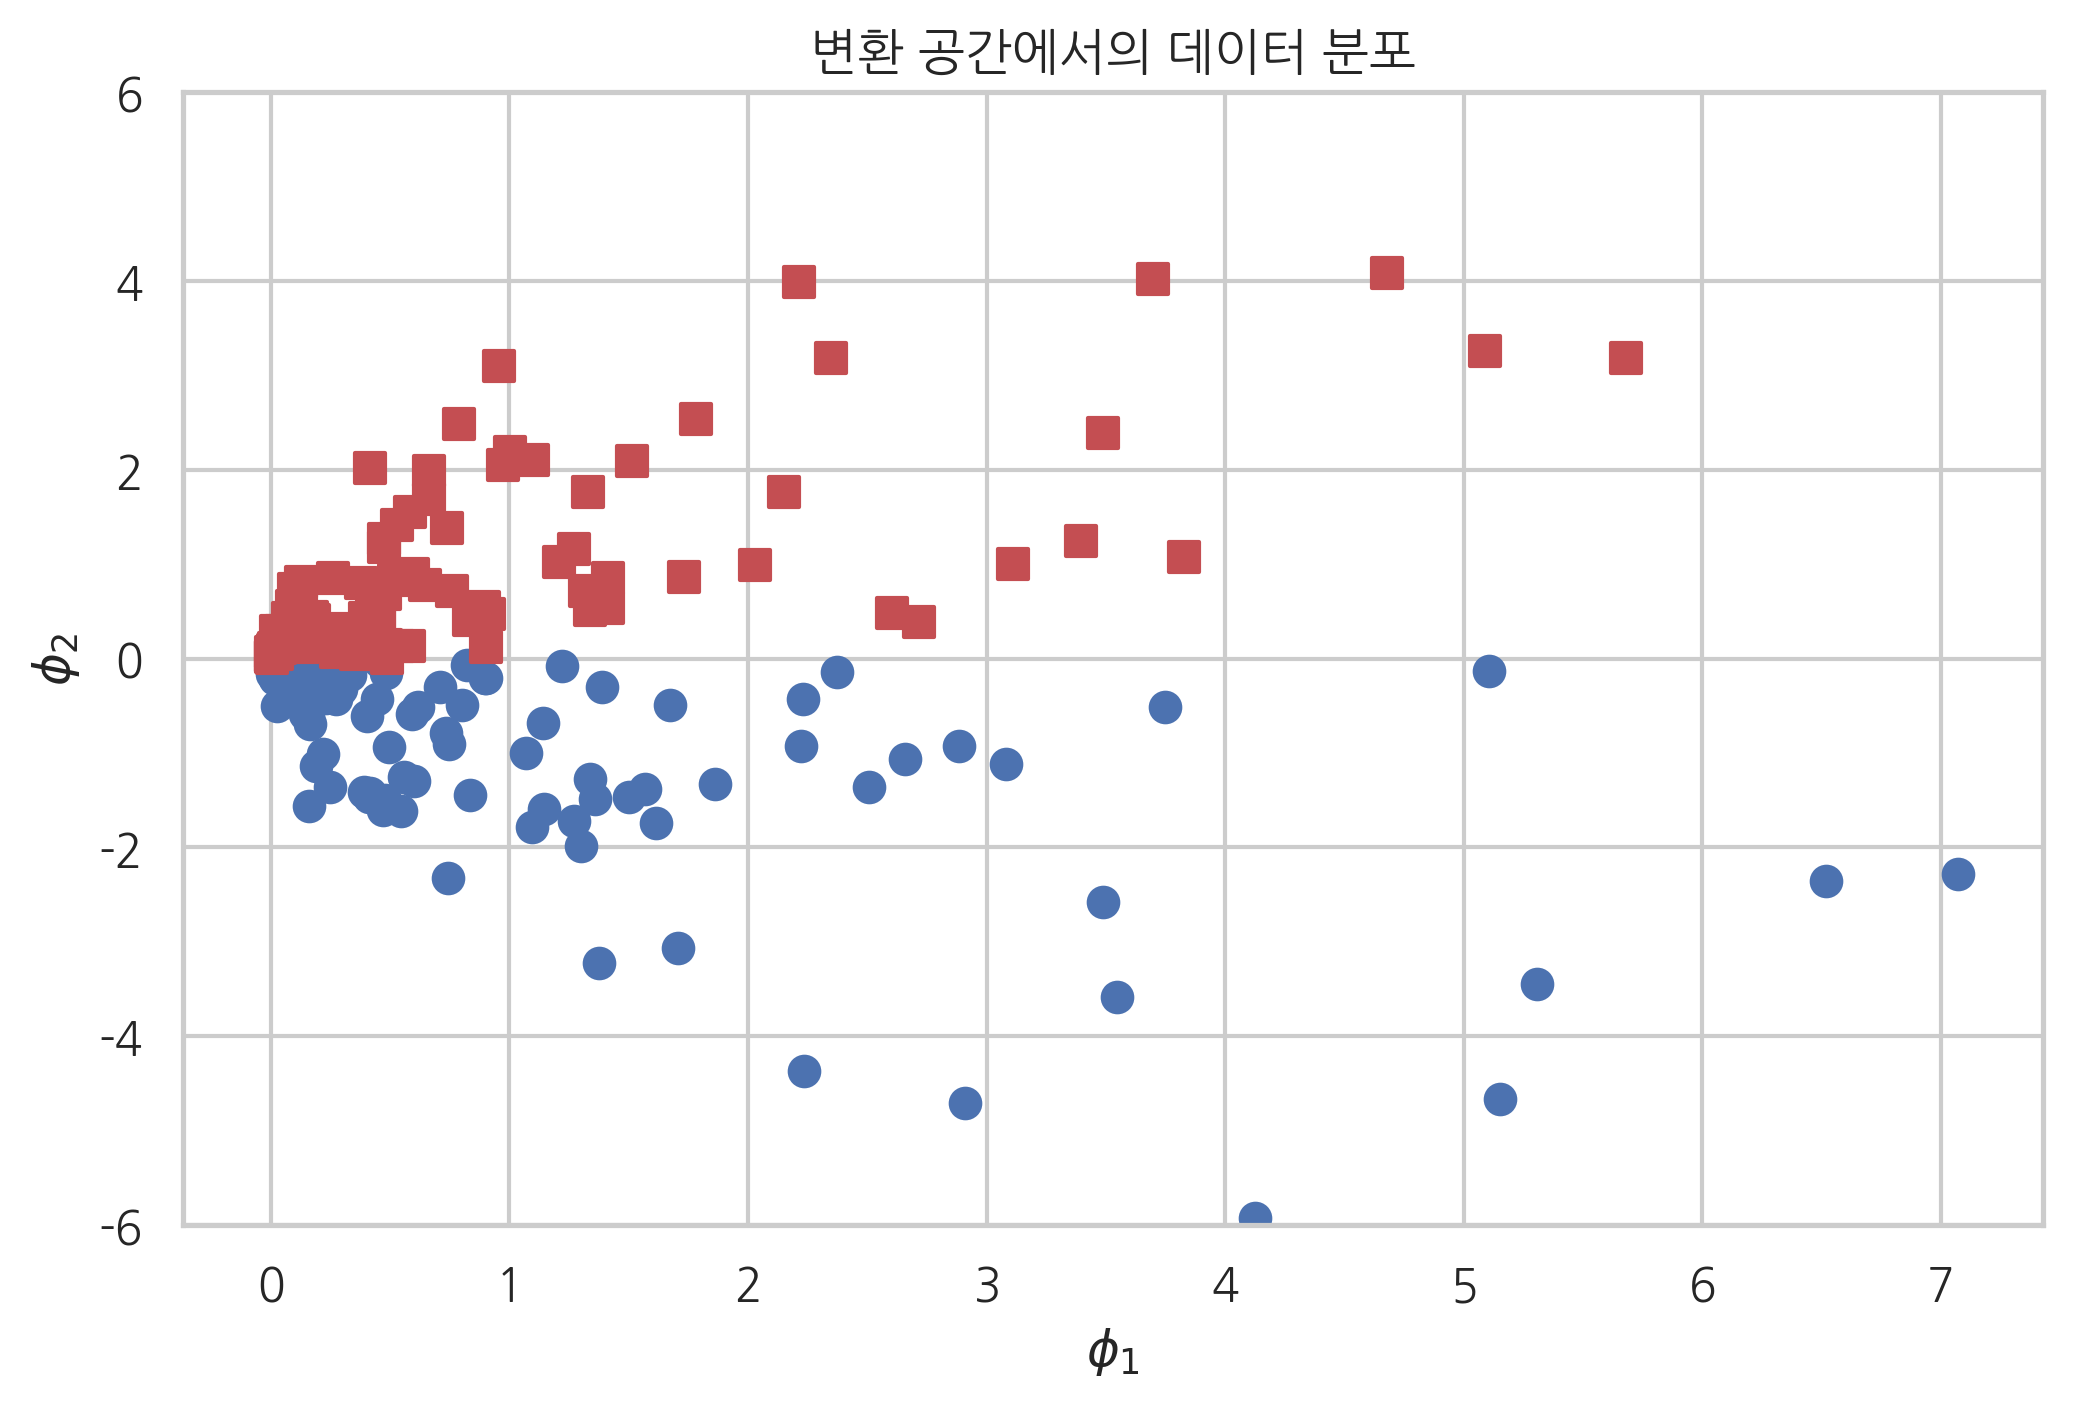

In [5]:
X_xor2 = FunctionTransformer(basis).fit_transform(X_xor)
plt.scatter(X_xor2[y_xor == 1, 0], X_xor2[y_xor == 1, 1], c="b", marker='o', s=50)
plt.scatter(X_xor2[y_xor == 0, 0], X_xor2[y_xor == 0, 1], c="r", marker='s', s=50)
plt.ylim(-6, 6)
plt.title("변환 공간에서의 데이터 분포")
plt.xlabel(r"$\phi_1$")
plt.ylabel(r"$\phi_2$")
plt.show()

다음 코드는 `Pipeline` 클래스로 기저함수 전치리기와 `SVC` 클래스를 합친 모형의 분류 결과이다.

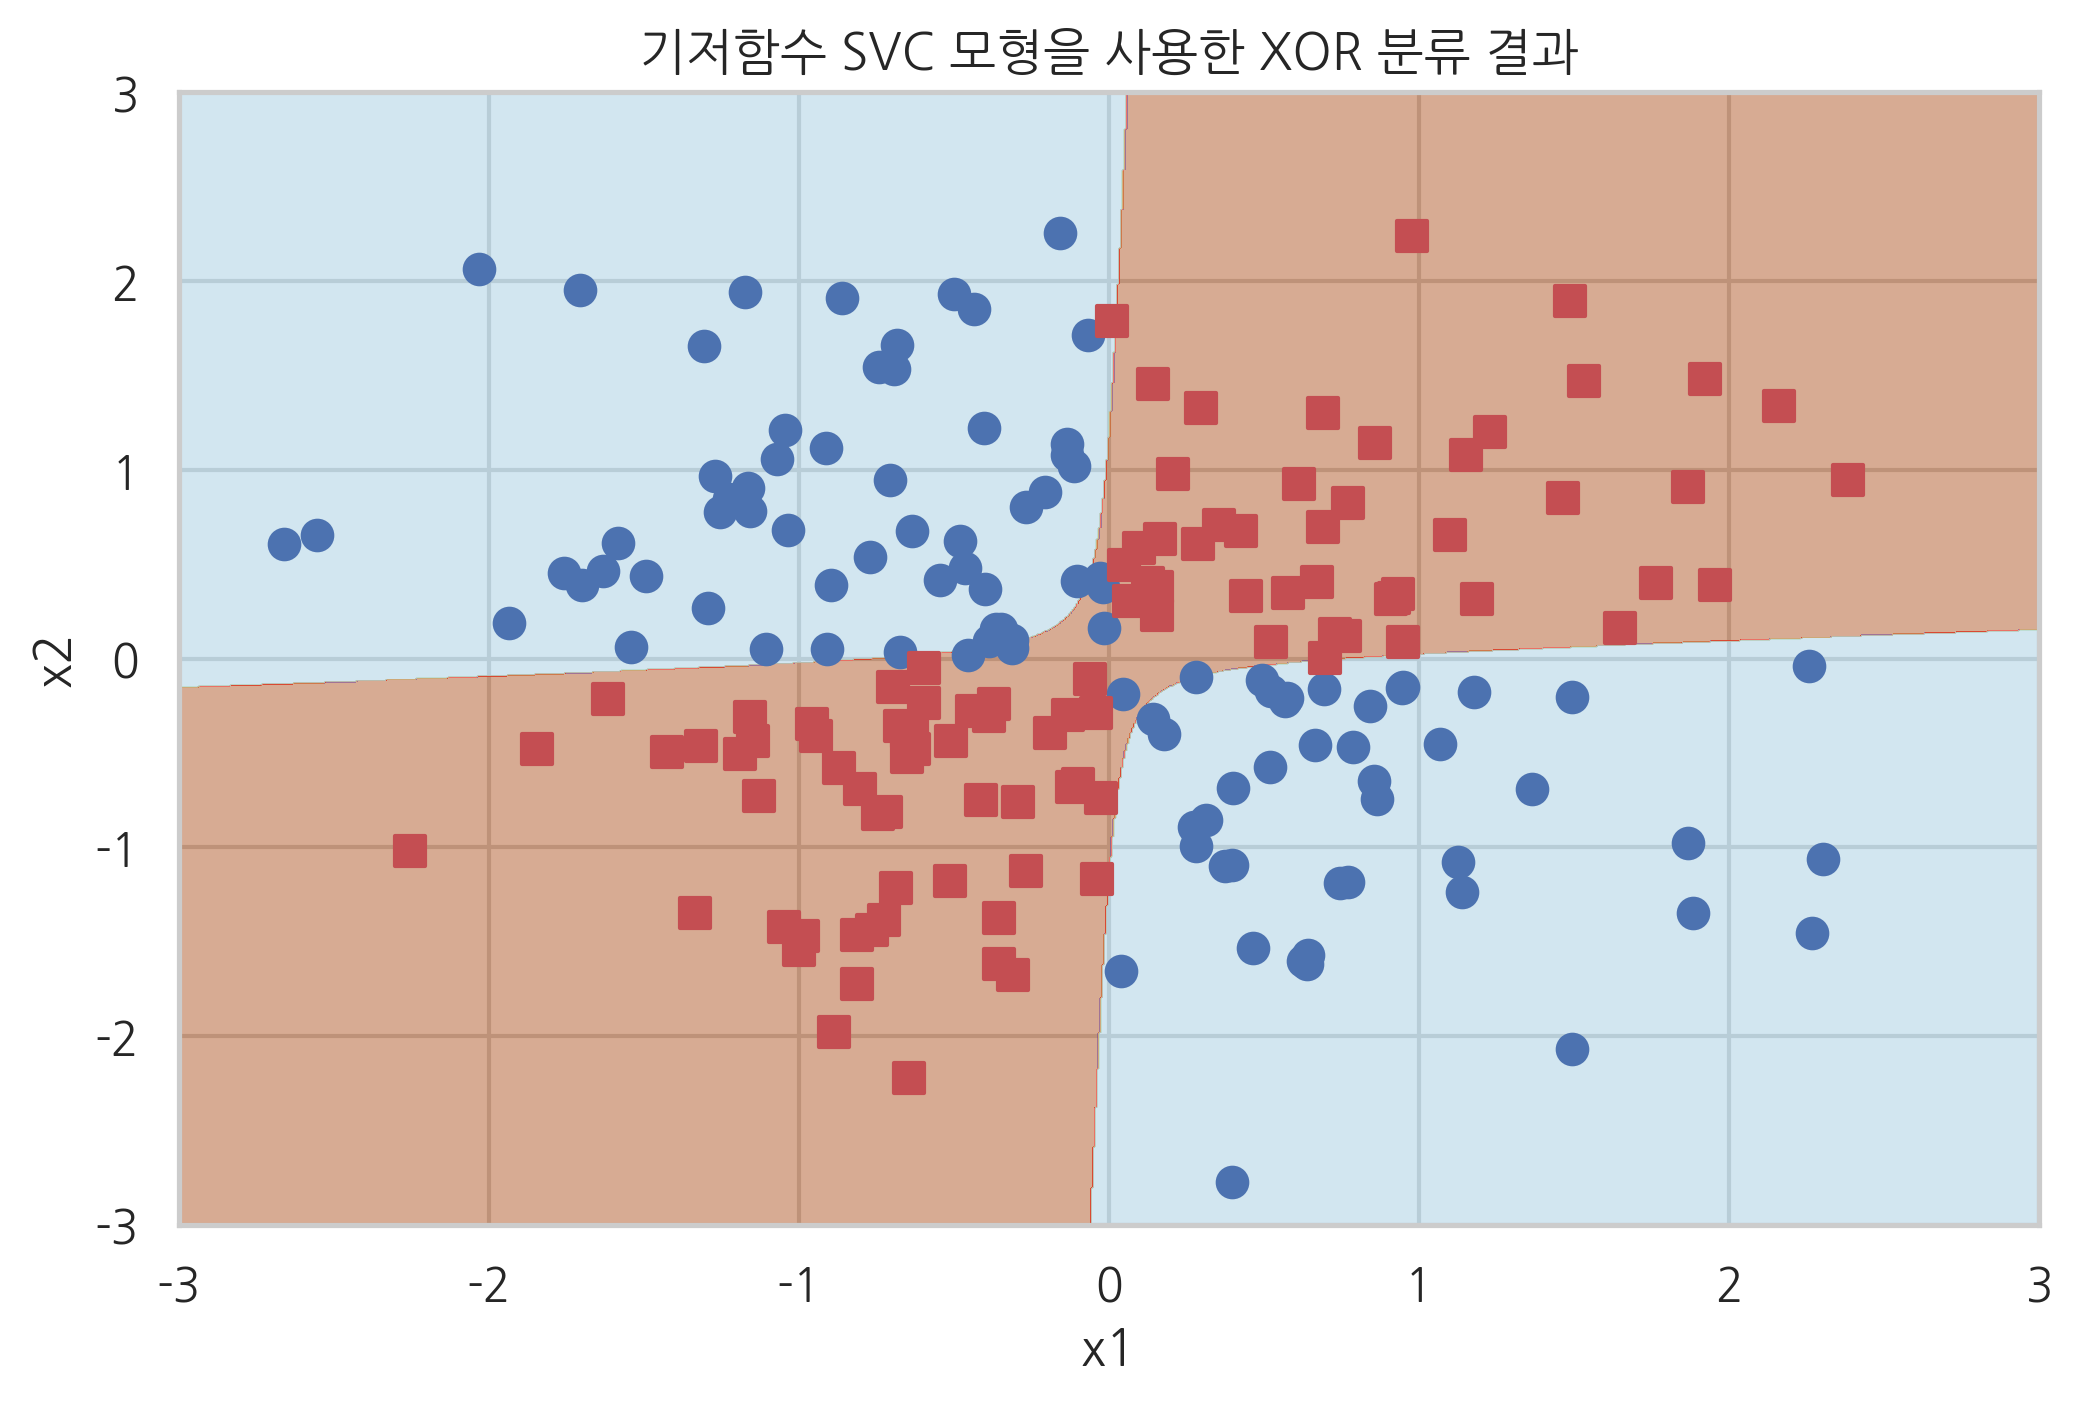

In [6]:
from sklearn.pipeline import Pipeline

basismodel = Pipeline([("basis", FunctionTransformer(basis)), 
                       ("svc", SVC(kernel="linear"))]).fit(X_xor, y_xor)
plot_xor(X_xor, y_xor, basismodel, "기저함수 SVC 모형을 사용한 XOR 분류 결과")
plt.show()

## 커널 트릭

서포트 벡터 머신의 경우 목적 함수와 예측 모형은 다음과 같은 dual form으로 표현할 수 있다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m x_n^T x_m
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n x_n^T x - w_0
$$

이 수식에서 $x$를 기저함수 변환으로 $\phi(x)$로 바꾸면

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m \phi(x_n)^T \phi(x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n \phi(x_n)^T \phi(x) - w_0
$$

이 된다. 즉 모든 기저함수는 $\phi(x_i)^T\phi(x_j)$의 형태로만 사용되며 독립적으로 사용되지 않는다.

따라서 두 개의 변환된 독립 변수 벡터를 내적(inner product) 한 값 $\phi(x_i)^T\phi(x_j)$를 하나의 함수로 나타낼 수 있다.

$$ k(x_i, x_j) = \phi(x_i)^T \phi(x_j) $$

이러한  함수를 커널(kernel)이라고 한다.

대응하는 기저함수가 존재할 수만 있다면 기저함수를 먼저 정의하고 커널을 정의하는 것이 아니라 커널을 먼저 정의해도 상관없다.  

## 커널의 의미

서포트 벡터 머신의 목적 함수와 예측 모형은 커널을 사용하여 표현하면 다음과 같다.

$$
L =  \sum_{n=1}^N a_n - \dfrac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m y_n y_m k(x_n, x_m)
$$


$$
y = w^T x - w_0 = \sum_{n=1}^N a_n y_n k(x_n, x) - w_0
$$

커널을 사용하지 않는 경우 $ k(x, y) = x^Ty $라는 점을 고려하면 커널은 다음과 같은 특징을 보인다.

* $x$와 $y$가 동일한 벡터일 때 가장 크고
* 두 벡터간의 거리가 멀어질 수록 작아진다.

즉, 두 표본 데이터 간의 유사도(similarity)를 측정하는 기준으로 볼 수도 있다. 

## 커널 사용의 장점

커널을 사용하면 베이시스 함수를 하나씩 정의하는 수고를 덜 수 있을뿐더러 변환과 내적에 들어가는 계산량이 줄어든다. 예를 들어, 다음과 같은 기저함수의 경우

$$ \phi(x_i) = \phi([x_{i,1}, x_{i,2}]) = (x_{i,1}^2, \sqrt{2}x_{i,1}x_{i,2}, x_{i,2}^2) $$

커널 방법을 쓰지 않을 경우에 $ \phi(x_i)^T \phi(x_j) $를 계산하려면 $4 + 4 + 3 = 11$ 번의 곱셈을 해야 한다.

* $\phi(x_1)$ 계산 : 곱셈 4회
* $\phi(x_2)$ 계산 : 곱셈 4회
* 내적: 곱셈 3회

그런데 이 기저함수는 다음과 같은 커널로 대체가능하다.

$$ 
\begin{eqnarray}
k(x_1, x_2) 
&=& (x_1^Tx_2)^2 \\
&=& (x_{1,1}x_{2,1} + x_{1,2}x_{2,2})^2 \\
&=& x_{1,1}^2x_{2,1}^2 + 2x_{1,1}x_{2,1}x_{1,2}x_{2,2} + x_{1,2}^2y_{2,2}^2 \\
&=& (x_{1,1}^2, \sqrt{2}x_{1,1}x_{1,2}, x_{1,2}^2)  (x_{2,1}^2, \sqrt{2}x_{2,1}x_{2,2}, x_{2,2}^2)^T \\
&=& \phi(x_1)^T \phi(x_2)
\end{eqnarray}
$$


커널을 사용하면  $ \phi(x_1)^T \phi(x_2) $ 을 계산하는데 $2 + 1 = 3$ 번의 곱셈이면 된다.
 
* $x_1^Tx_2$: 곱셈 2회
* 제곱: 곱셈 1회

## 커널의 확장 생성

어떤 함수가 커널함수가 된다는 것을 증명하기 위해서는 기저함수를 하나 하나 정의할 필요없이 기저함수의 내적으로 표현할 수 있다는 것만 증명하면 된다. 하지만 실제로는 다음 규칙을 이용하면 이미 만들어진 커널 $k_1(x_1, x_2)$, $k_2(x_1, x_2)$로부터 새로운 커널을 쉽게 만들 수 있다.

1. 커널함수를 양수배한 함수는 커널함수이다.
$$k(x_1, x_2) = ck_1(x_1, x_2)\;\;(c > 0)$$ <br>
1. 커널함수에 양수인 상수를 더한 함수는 커널함수이다.
$$k(x_1, x_2) = k_1(x_1, x_2) + c\;\;(c > 0)$$ <br>
1. 두 커널함수를 더한 함수는 커널함수이다.
$$k(x_1, x_2) = k_1(x_1, x_2) + k_2(x_1, x_2)$$ <br>
1. 두 커널함수를 곱한 함수는 커널함수이다.
$$k(x_1, x_2) = k_1(x_1, x_2)k_2(x_1, x_2)$$ <br>
1. 커널함수를 $x\geq0$에서 단조증가(monotonically increasing)하는 함수에 적용하면 커널함수이다.
$$k(x_1, x_2) = (k_1(x_1, x_2))^n \;\; (n=1, 2, \cdots)$$
$$k(x_1, x_2) = \exp(k_1(x_1, x_2))$$
$$k(x_1, x_2) = \text{sigmoid}(k_1(x_1, x_2))$$
1. $x_1, x_2$ 각각의 커널함수값의 곱도 커널함수이다.
$$k(x_1, x_2) = k_1(x_1, x_1)k_2(x_2, x_2) $$


## 많이 사용되는 커널

다음과 같은 커널들이 많이 사용되는 커널들이다. 이 커널들은 대부분 기저함수로 변환하였을 때 무한대의 차원을 가지는 기저함수가 된다. 따라서 대부분의 비선형성을 처리할 수 있다. 비교를 위해 선형 서포트 벡터 머신의 경우도 추가하였다.


* 선형 서포트 벡터 머신

$$ k(x_1, x_2) = x_1^Tx_2 $$


* 다항 커널 (Polynomial Kernel)

$$ k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d $$


* RBF(Radial Basis Function) 또는 가우시안 커널(Gaussian Kernel)

$$ k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right) $$


* 시그모이드 커널 (Sigmoid Kernel)

$$ k(x_1, x_2) = \tanh(\gamma (x_1^Tx_2) + \theta) $$


앞에서 사용한 기저함수는 $\gamma = 1, \theta= 0, d=2$ 인 다항 커널임을 알 수 있다.

## 다항 커널

다항 커널은 벡터의 내적으로 정의된 커널을 확장하여 만든 커널이다. 다항 커널이 어떤 기저함수로 되어 있는지 알아보자.

간단한 경우로 $\gamma=1$, $\theta=1$, $d=3$이고 $x$가 스칼라인 경우에는

$$ 
\begin{eqnarray}
k(x_1, x_2) 
&=& (x_1^Tx_2 + 1)^4 \\
&=& x_1^4x_2^4 + 4x_1^3x_2^3 + 6x_1^2x_2^2 + 4x_1x_2 + 1 \\
&=& (x_1^4, 2x_1^3, \sqrt{6}x_1, 2x_1, 1)^T (x_2^4, 2x_2^3, \sqrt{6}x_2, 2x_2, 1) \ \\
\end{eqnarray}
$$

처럼 기저함수의 내적이 된다. 즉, 기저함수는 다음 5개가 된다.

$$
\begin{eqnarray}
\phi_1(x) &=& x^4 \\
\phi_2(x) &=& 2x^3 \\
\phi_3(x) &=& \sqrt{6}x^2 \\
\phi_4(x) &=& 2x \\
\phi_5(x) &=& 1 \\
\end{eqnarray}
$$

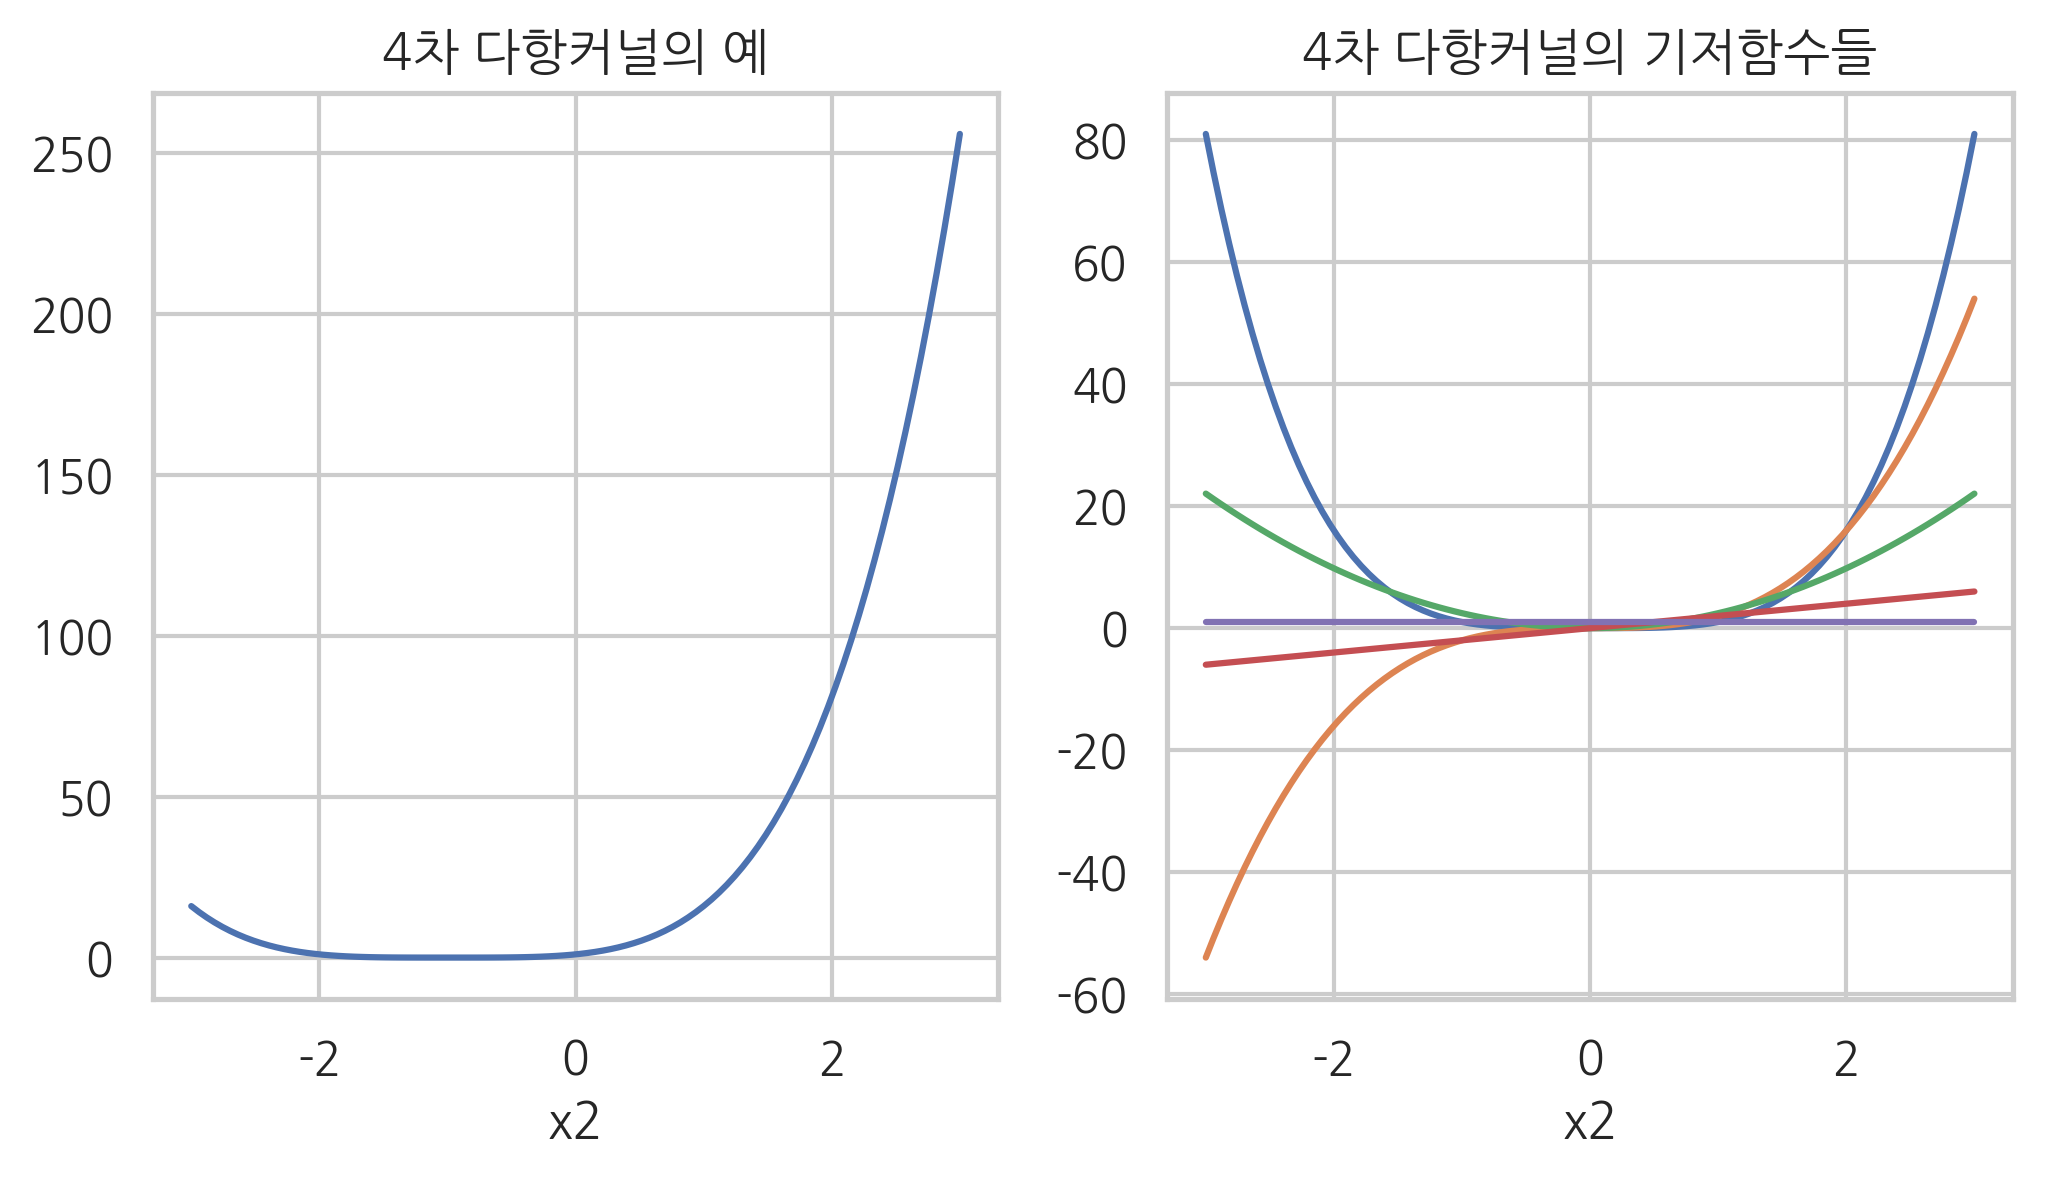

In [7]:
x1 = 1
x2 = np.linspace(-3, 3, 100)

def poly4(x1, x2):
    return (x1 * x2 + 1) ** 4

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x2, poly4(x1, x2), ls="-")
plt.xlabel("x2")
plt.title("4차 다항커널의 예")

plt.subplot(122)
plt.plot(x2, x2 ** 4)
plt.plot(x2, 2 * x2 ** 3)
plt.plot(x2, np.sqrt(6) * x2 ** 2)
plt.plot(x2, 2 * x2)
plt.plot(x2, np.ones_like(x2))
plt.xlabel("x2")
plt.title("4차 다항커널의 기저함수들")

plt.show()

## RBF 커널

RBF 커널은 가우시안 커널이라고도 한다. 문제를 간단하게 하기 위해 다음과 같이 가정한다.

$$
\gamma=\frac{1}{2}
$$

$$
\|x_1\| = \|x_2\| = 1
$$

그러면 RBF 커널은

$$ 
\begin{eqnarray}
k(x_1, x_2) 
&=& \exp{\left(-\frac{||x_1 - x_2||^2}{2}\right)} \\
&=& \exp{\left(-\frac{x_1^Tx_1}{2} - \frac{x_2^Tx_2}{2} + 2x_1^Tx_2 \right)} \\
&=& \exp{\left(-\frac{x_1^Tx_1}{2}\right)}\exp{\left(-\frac{x_2^Tx_2}{2}\right)}\exp{(x_1^Tx_2)} \\
&=& C \exp{(x_1^Tx_2)} \\
&\approx& C \left( 1 + (x_1^Tx_2) + \dfrac{1}{2!}(x_1^Tx_2)^2 +  \dfrac{1}{3!}(x_1^Tx_2)^3 + \cdots \right) \\
\end{eqnarray}
$$

에서 차수가 무한대인 다항커널과 같다. 

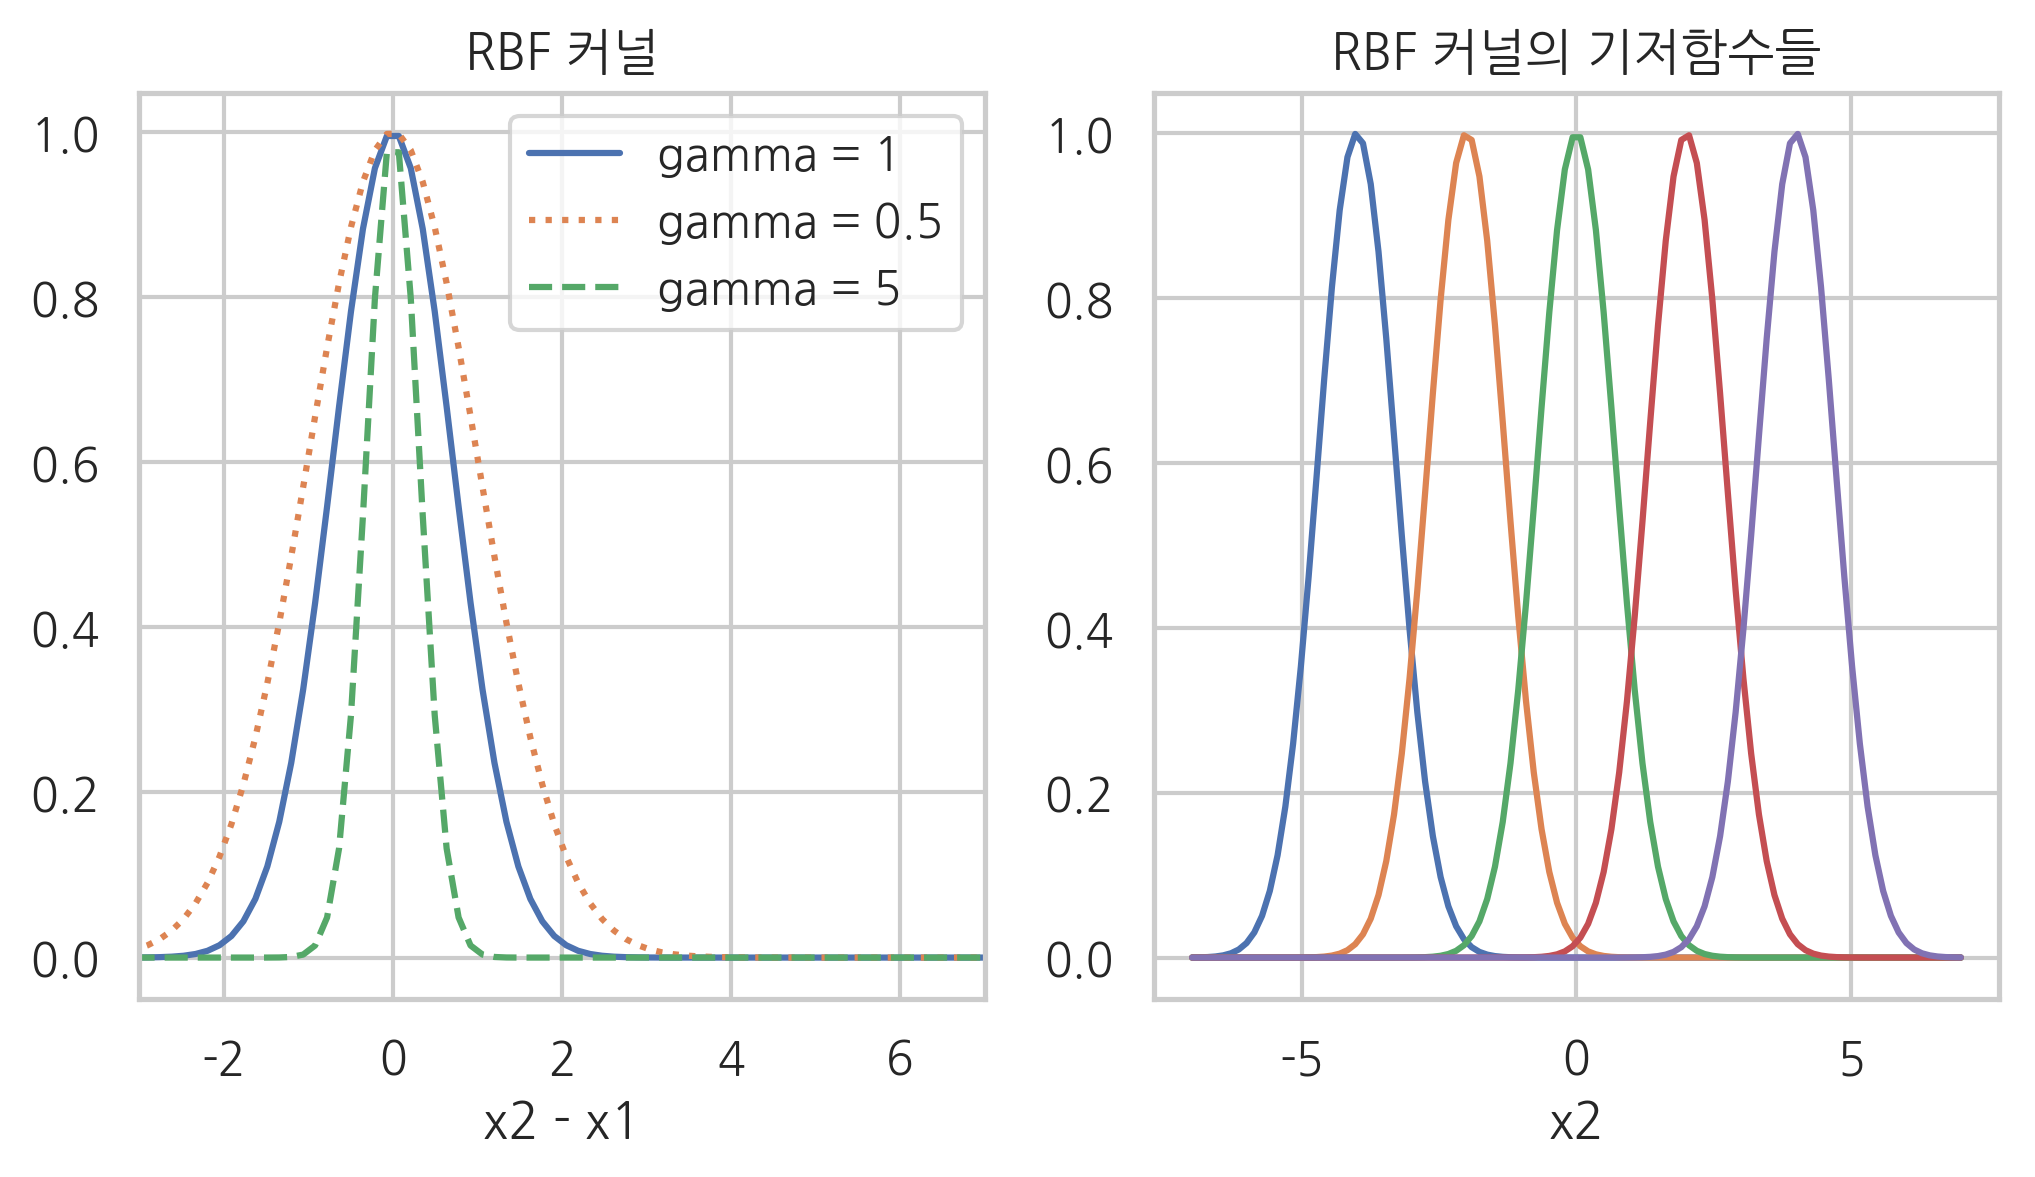

In [8]:
x1 = 0.0
x2 = np.linspace(-7, 7, 100)

def rbf(x1, x2, gamma):
    return np.exp(-gamma * np.abs(x2 - x1) ** 2)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(x2, rbf(x1, x2, 1), ls="-", label="gamma = 1")
plt.plot(x2, rbf(x1, x2, 0.5), ls=":", label="gamma = 0.5")
plt.plot(x2, rbf(x1, x2, 5), ls="--", label="gamma = 5")
plt.xlabel("x2 - x1")
plt.xlim(-3, 7)
plt.legend(loc=1)
plt.title("RBF 커널")

plt.subplot(122)
plt.plot(x2, rbf(-4, x2, 1))
plt.plot(x2, rbf(-2, x2, 1))
plt.plot(x2, rbf(0, x2, 1))
plt.plot(x2, rbf(2, x2, 1))
plt.plot(x2, rbf(4, x2, 1))
plt.xlabel("x2")
plt.title("RBF 커널의 기저함수들")

plt.show()

## scikit-learn의 커널 SVM

scikit-learn의 `SVM` 클래스는 `kernel` 인수를 지정하여 커널을 설정할 수 있다.

* `kernel = "linear"`: 선형 SVM. $k(x_1, x_2) = x_1^T x_2$ 
* `kernel = "poly"`: 다항 커널. $k(x_1, x_2) = (\gamma (x_1^Tx_2) + \theta)^d$ 
    * `gamma`: $\gamma$
    * `coef0`: $\theta$
    * `degree`: $d$
* `kernel = "rbf"` 또는 `kernel = None`: RBF 커널. $k(x_1, x_2) = \exp \left( -\gamma ||x_1-x_2||^2 \right)$
    * `gamma`: $\gamma$
* `kernel = "sigmoid"`: 시그모이드 커널. $k(x_1, x_2) = \tanh(\gamma (x_1^Tx_2) + \theta)$
    * `gamma`: $\gamma$
    * `coef0`: $\theta$


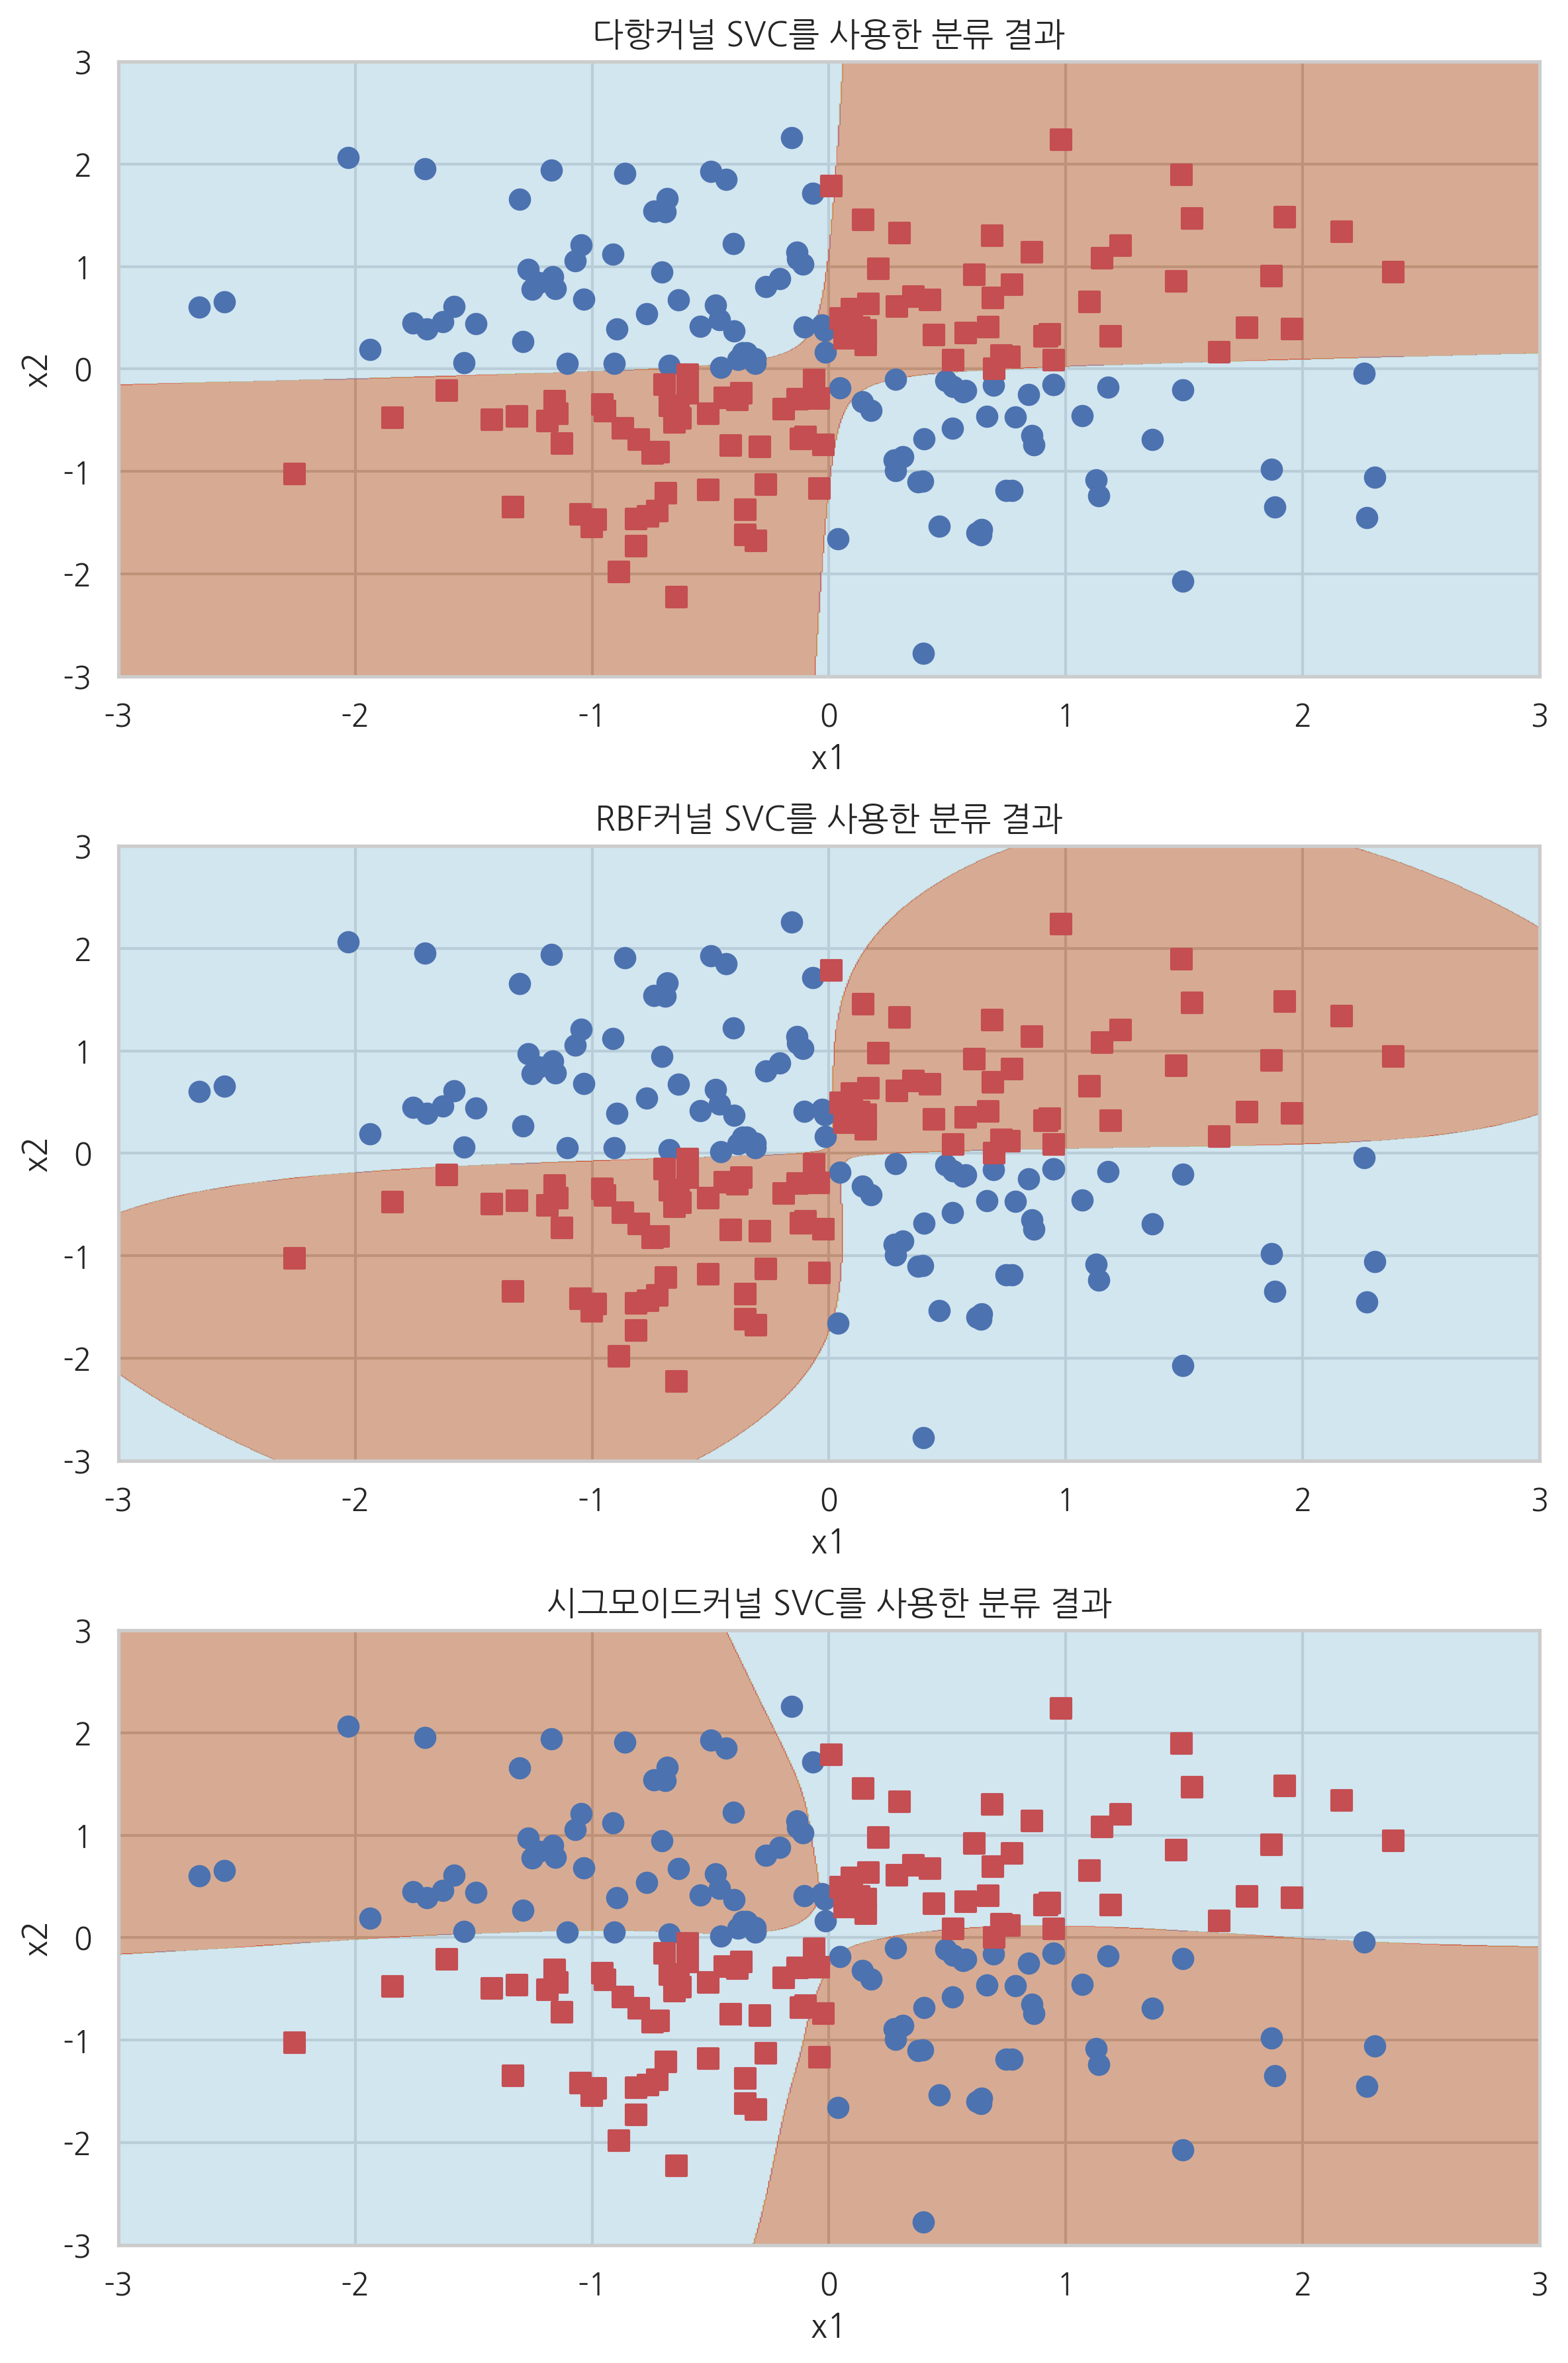

In [9]:
polysvc = SVC(kernel="poly", degree=2, gamma=1, coef0=0).fit(X_xor, y_xor)
rbfsvc = SVC(kernel="rbf").fit(X_xor, y_xor)
sigmoidsvc = SVC(kernel="sigmoid", gamma=2, coef0=2).fit(X_xor, y_xor)

plt.figure(figsize=(8, 12))
plt.subplot(311)
plot_xor(X_xor, y_xor, polysvc, "다항커널 SVC를 사용한 분류 결과")
plt.subplot(312)
plot_xor(X_xor, y_xor, rbfsvc, "RBF커널 SVC를 사용한 분류 결과")
plt.subplot(313)
plot_xor(X_xor, y_xor, sigmoidsvc, "시그모이드커널 SVC를 사용한 분류 결과")
plt.tight_layout()
plt.show()

## 커널 파라미터의 영향

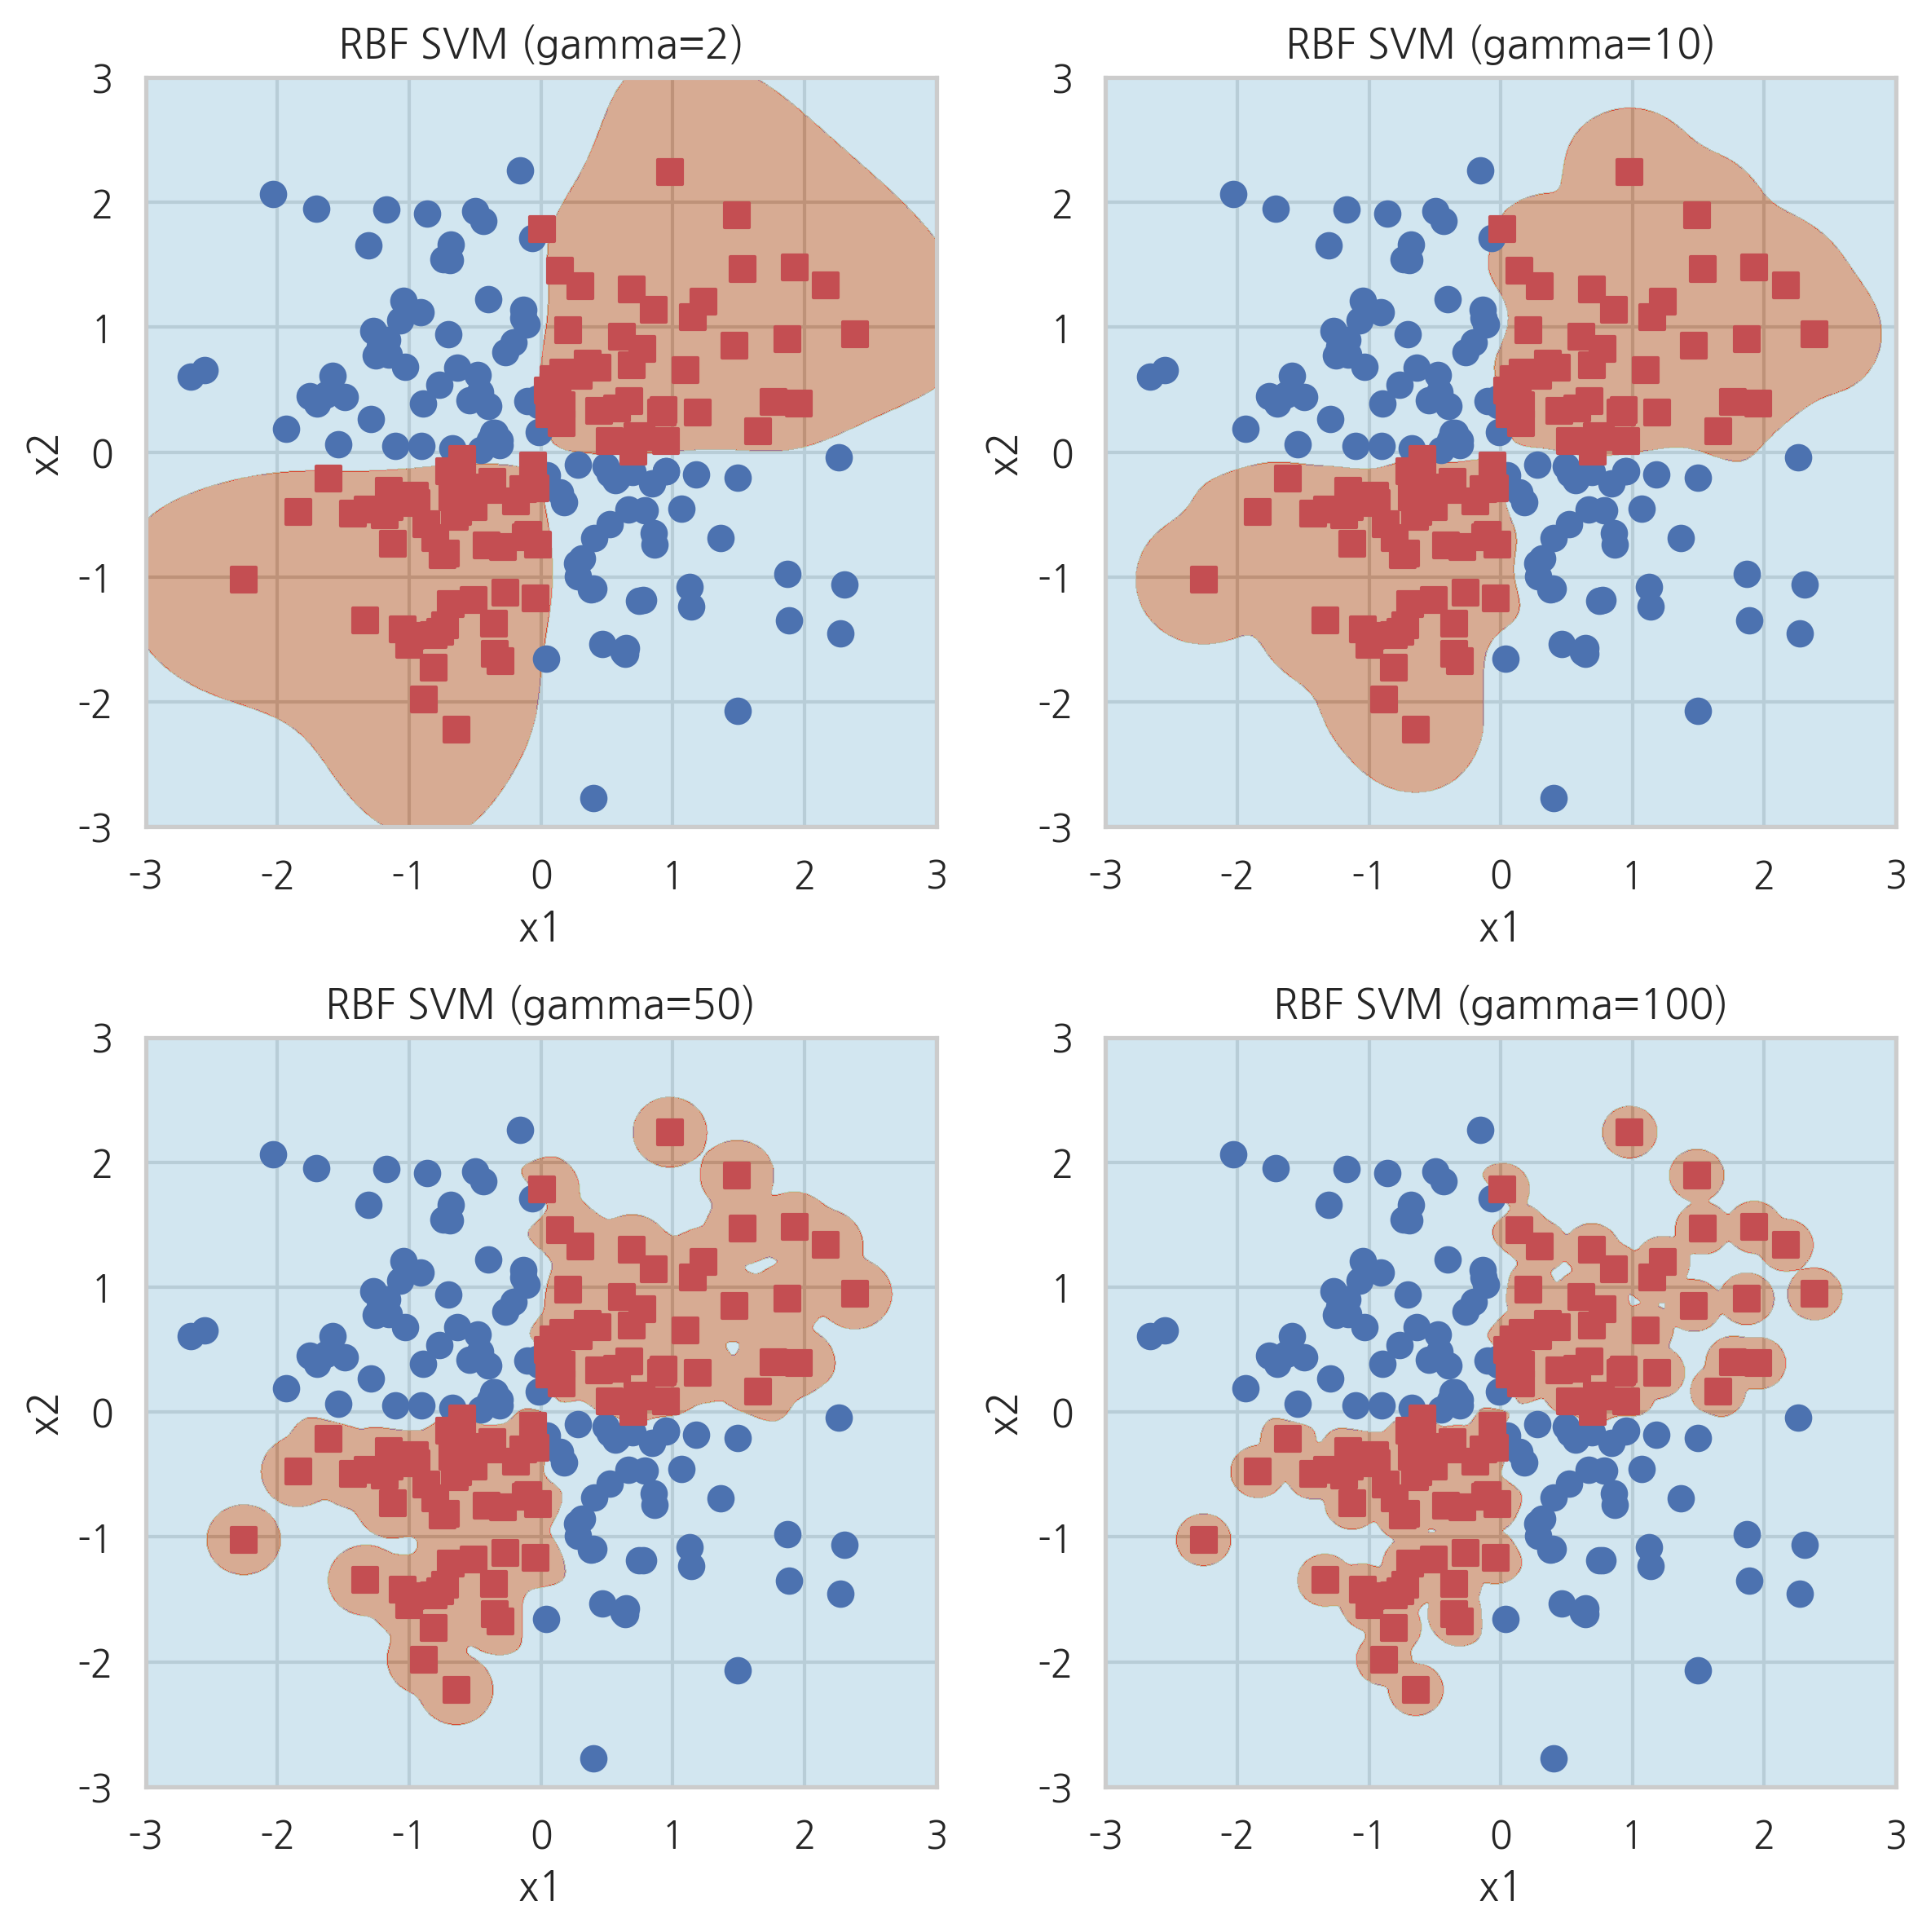

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=2).fit(X_xor, y_xor), "RBF SVM (gamma=2)")
plt.subplot(222)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=10).fit(X_xor, y_xor), "RBF SVM (gamma=10)")
plt.subplot(223)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=50).fit(X_xor, y_xor), "RBF SVM (gamma=50)")
plt.subplot(224)
plot_xor(X_xor, y_xor, SVC(kernel="rbf", gamma=100).fit(X_xor, y_xor), "RBF SVM (gamma=100)")
plt.tight_layout()
plt.show()

## 붓꽃 문제에의 응용

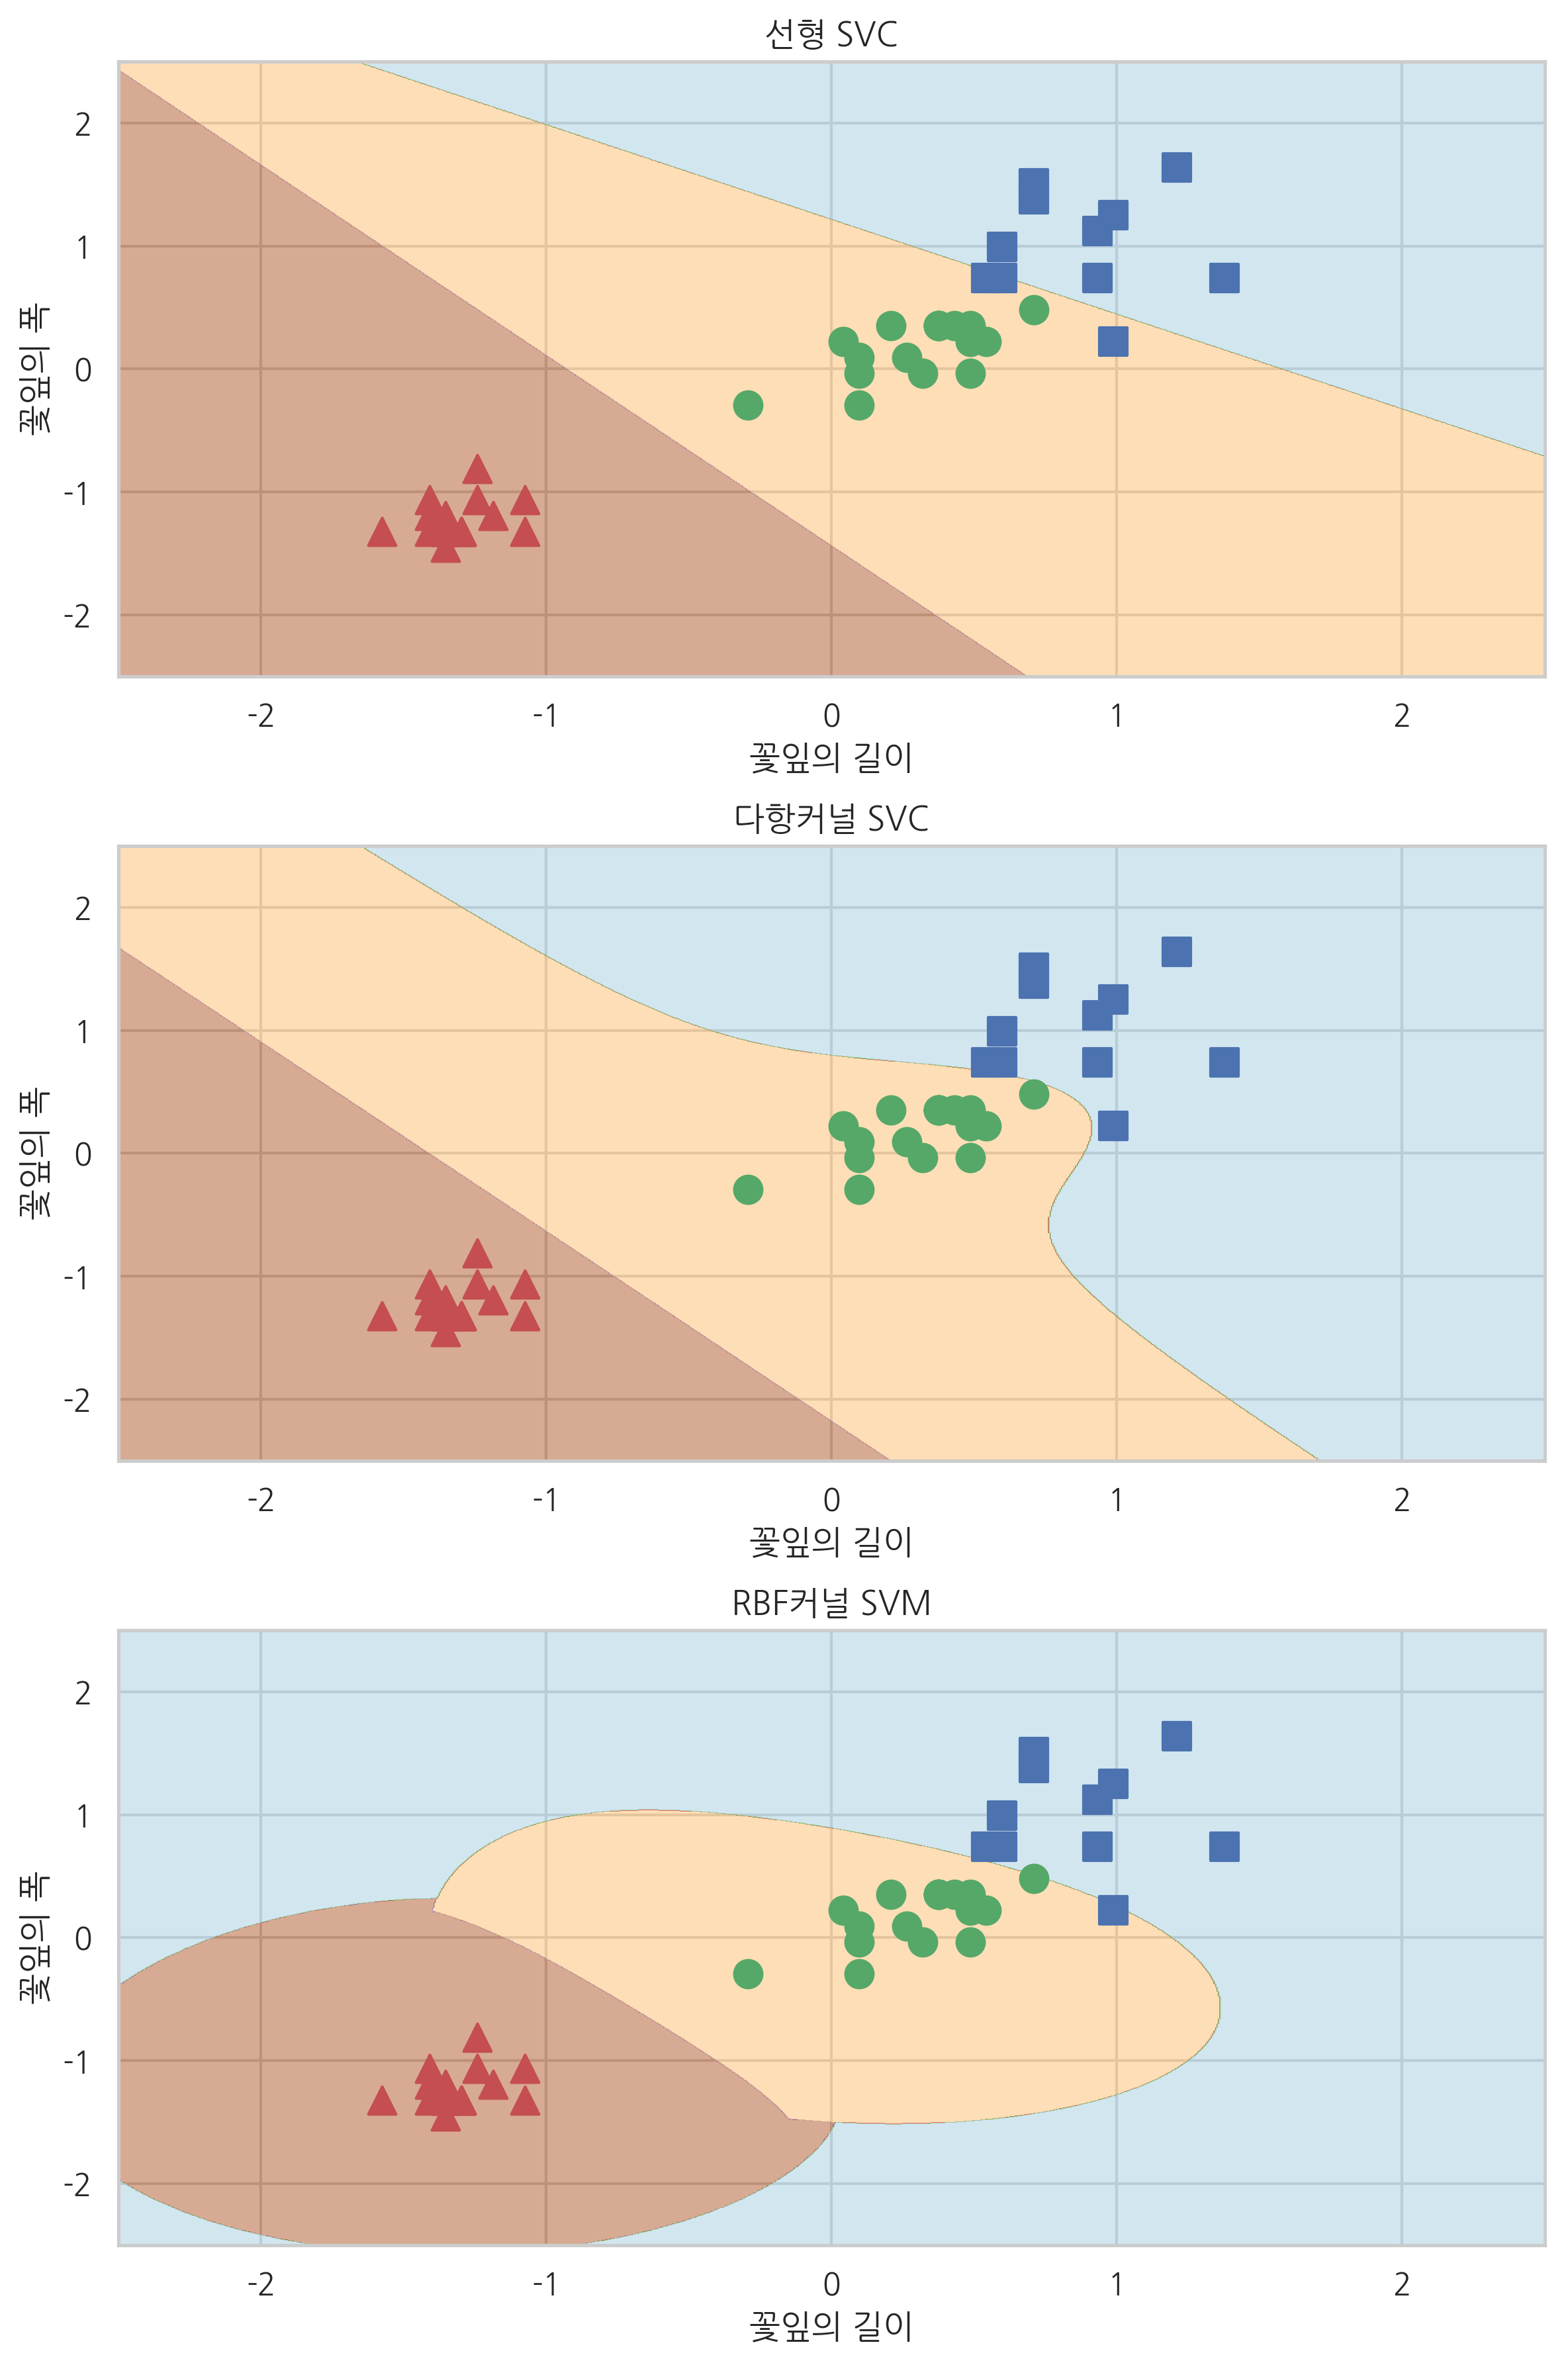

In [11]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))


def plot_iris(X, y, model, title, xmin=-2.5, xmax=2.5, ymin=-2.5, ymax=2.5):
    XX, YY = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)/1000),
                         np.arange(ymin, ymax, (ymax-ymin)/1000))
    ZZ = np.reshape(model.predict(np.array([XX.ravel(), YY.ravel()]).T), XX.shape)
    plt.contourf(XX, YY, ZZ, cmap=mpl.cm.Paired_r, alpha=0.5)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', marker='^', label='0', s=100)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='g', marker='o', label='1', s=100)
    plt.scatter(X[y == 2, 0], X[y == 2, 1], c='b', marker='s', label='2', s=100)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("꽃잎의 길이")
    plt.ylabel("꽃잎의 폭")
    plt.title(title)


model1 = SVC(kernel='linear').fit(X_test_std, y_test)
model2 = SVC(kernel='poly', random_state=0,
             gamma=10, C=1.0).fit(X_test_std, y_test)
model3 = SVC(kernel='rbf', random_state=0, gamma=1,
             C=1.0).fit(X_test_std, y_test)

plt.figure(figsize=(8, 12))
plt.subplot(311)
plot_iris(X_test_std, y_test, model1, "선형 SVC")
plt.subplot(312)
plot_iris(X_test_std, y_test, model2, "다항커널 SVC")
plt.subplot(313)
plot_iris(X_test_std, y_test, model3, "RBF커널 SVM")
plt.tight_layout()
plt.show()